In [1]:
import torch
from torch import nn
import pandas as pd
import math
from d2l import torch as d2l

In [2]:
'''
unsqueeze 增加维度
repeat_interleave(tensor,repeat_time,dim) 对每个元素重复
        >>> y = torch.tensor([[1, 2], [3, 4]])
        >>> torch.repeat_interleave(y, 2) 重复2次，没有写维度，默认展平
        tensor([1, 1, 2, 2, 3, 3, 4, 4])
        >>> torch.repeat_interleave(y, 3, dim=1) 维度为1重复三次，即维度1的数目要乘3
        tensor([[1, 1, 1, 2, 2, 2],
                [3, 3, 3, 4, 4, 4]])
        >>> torch.repeat_interleave(y, torch.tensor([1, 2]), dim=0)维度为0重复1、2次，即维度0的数目要变成3
        tensor([[1, 2],
                [3, 4],
                [3, 4]])
'''

def masked_softmax(X,valid_lens,value=0):
    '''
    X是评分矩阵(batch_size,num_queries,num_keys)
    valid_lens (batch_size)或者(batch_size,num_queries) 有效长度是基于闻讯来的，每个闻讯一个有效长度
    '''
    def _masked_softmax(X,valid_lens,value=0):
        '''
        这个函数针对同一个问询
        X (batch_size, max_len=num_keys)
        valid_lens (batch_size,)
        '''
        max_len=X.size(1)
        mask=torch.arange((max_len),dtype=torch.float32,device=X.device)
        # mask(1,max_len)
        mask=mask.unsqueeze(dim=0)
        # valid_lens(batch_size,1)
        valid_lens=valid_lens.unsqueeze(dim=1)
        new_mask=mask<valid_lens
        X[~new_mask]=value
        return X
    if valid_lens is None:
        return nn.functional.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_lens.dim()==1:
            valid_lens=torch.repeat_interleave(valid_lens,X.shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
        X=X.reshape(-1,X.shape[-1])
        #上述操作以后，X和valid_lens的第一维度均为batch_size*num_queries
        result=_masked_softmax(X,valid_lens,-1e6)
        return nn.functional.softmax(result.reshape(shape),dim=-1)
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])))



tensor([[[0.4377, 0.5623, 0.0000, 0.0000],
         [0.4541, 0.5459, 0.0000, 0.0000]],

        [[0.2503, 0.5295, 0.2202, 0.0000],
         [0.3534, 0.1981, 0.4485, 0.0000]]])


In [3]:
'''
bmm 矩阵乘法，第一个维度batch_size不变，遍历batch_size个样本，对于每个样本做矩阵惩罚
'''
class DotProductAttention(nn.Module):
    '''
    queries,keys,values都是(batch_size,num_steps,num_dims)
    输出注意力矩阵(batch_size,num_steps_queries,num_dims_values)
    '''
    def __init__(self,dropout):
        super().__init__()
        self.dropout=nn.Dropout(dropout)
    def forward(self,queries,keys,values,valid_lens=None):
        d=queries.shape[-1]
        scores=torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores,valid_lens)
        #print(self.attention_weights.shape)
        result=torch.bmm(self.dropout(self.attention_weights),values)
        #print(result.shape)
        return result
    
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_hiddens,num_heads,dropout,bias=False,**kwargs):
        '''
        注意 num_hiddens必须是num_heads的整数倍！
        原则上，W_v的维度是可以不同的，但是后面要残差连接，故把它设置为相同
        '''
        super().__init__()
        self.num_heads=num_heads
        self.attention=DotProductAttention(dropout)
        self.W_q=nn.LazyLinear(num_hiddens,bias=bias)
        self.W_k=nn.LazyLinear(num_hiddens,bias=bias)
        self.W_v=nn.LazyLinear(num_hiddens,bias=bias)
        self.W_o=nn.LazyLinear(num_hiddens,bias=bias)
    def transpose_qkv(self,X):
        '''
        这里X是经过线性层的query/keys/values之一(batch_size,num_steps,num_hiddens)
        输出(batch_size*num_heads,num_steps,num_hiddens/num_heads)
        '''
        # X(batch_size,num_steps,num_heads,num_hiddens/num_heads)
        X=X.reshape(X.shape[0],X.shape[1],self.num_heads,-1)
        # X(batch_size,num_heads,num_steps,num_hiddens/num_heads)
        X=X.permute(0,2,1,3)
        # 返回(batch_size*num_heads,num_steps,num_hiddens/num_heads)
        return X.reshape(-1,X.shape[2],X.shape[3])
    def transpose_output(self,X):
        '''
        X (batch_size*num_heads,num_steps_queries,num_hiddens/num_heads)
        返回(batch_size,num_steps_queries,num_hiddens)
        '''
        X=X.reshape(-1,self.num_heads,X.shape[1],X.shape[2])
        X=X.permute(0,2,1,3)
        return X.reshape(X.shape[0],X.shape[1],-1)

    def forward(self,oringinal_queries,original_keys,original_values,valid_lens):
        queries=self.transpose_qkv(self.W_q(oringinal_queries))
        keys=self.transpose_qkv(self.W_k(original_keys))
        values=self.transpose_qkv(self.W_v(original_values))
        if valid_lens is not None:
            valid_lens=torch.repeat_interleave(valid_lens,repeats=self.num_heads,dim=0)
        # result(batch_size*num_heads,num_steps_queries,num_dims_values=num_hiddens/num_heads)
        result=self.attention(queries,keys,values,valid_lens)
        # output(batch_size,num_steps_queries,num_hiddens)
        output=self.transpose_output(result)
        # 返回(batch_size,num_steps_queries,num_hiddens)
        return self.W_o(output)
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),(batch_size, num_queries, num_hiddens))

In [5]:
class AddNorm(nn.Module):
    def __init__(self,norm_shape,drop_rate):
        super().__init__()
        self.dropout=nn.Dropout(drop_rate)
        self.ln=nn.LayerNorm(norm_shape)
    def forward(self,X,Y):
        return self.ln(self.dropout(Y)+X)

In [6]:
class PositionWiseFFN(nn.Module):
    def __init__(self,ffn_num_hiddens,num_outputs):
        super().__init__()
        self.dense1=nn.LazyLinear(ffn_num_hiddens)
        self.relu=nn.ReLU()
        self.dense2=nn.LazyLinear(num_outputs)
    def forward(self,X):
        return self.dense2(self.relu(self.dense1(X)))
 

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self,num_hiddens,ffn_num_hiddens,num_heads,dropout,bias=False):
        super().__init__()
        self.multi_attention=MultiHeadAttention(num_hiddens,num_heads,dropout,bias)
        self.addnorm1=AddNorm(num_hiddens,dropout)
        self.addnorm2=AddNorm(num_hiddens,dropout)
        self.ffn=PositionWiseFFN(ffn_num_hiddens,num_hiddens)# 把num_outputs设置为num_hiddens，这样才能残差连接
    def forward(self,X,valid_lens):
        Y=self.addnorm1(X,self.multi_attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))


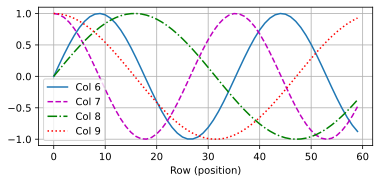

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,encoding_dim,dropout,max_len=1000):
        '''
        这里设置max_len有一种lazy的感觉，原本X为(batch_size,num_steps,encoding_dim)的，这里batch_size可以由广播得到，但是序列长度需要给定X才知道
        '''
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.P=torch.zeros((1,max_len,encoding_dim))
        X=torch.arange(max_len,dtype=torch.float32).reshape(-1,1)
        Y=torch.pow(10000,torch.arange(0,encoding_dim,2,dtype=torch.float32)/encoding_dim)
        X=X/Y
        self.P[:,:,0::2]=torch.sin(X)
        self.P[:,:,1::2]=torch.cos(X)
    def forward(self,X):
        X=X+self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [9]:
'''
nn.Embedding 词汇表大小，输出维度
forward函数会把句子转换为(num_steps,num_hiddens)
'''
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,num_heads, num_blocks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blocks = nn.Sequential()
        for i in range(num_blocks):
            self.blocks.add_module("block"+str(i), EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))
    def forward(self, X, valid_lens):
        #乘后面这一项为了让词嵌入向量和位置编码向量在相加时，两者的量级保持一个合理的平衡
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blocks)
        for i, block in enumerate(self.blocks):
            X = block(X, valid_lens)
            self.attention_weights[i] = block.multi_attention.attention.attention_weights
        return X

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self,num_hiddens,ffn_num_hiddens,num_heads,dropout,i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads,dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads,dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    def forward(self,X,state):
        '''
        state[0]是编码器输出
        state[1]是编码器的有效长度
        state[2]是输入的缓存，这只有在推理时有效
        推理时，输入的X是(batch_size,1,num_dims)，每次经过一轮解码器，输出下一个词，把它作为新的输入
        这样就需要用state[2]缓存之前的状态。
        在训练时，由于是直接喂给正确的句子，所以每个batch只有一次前向传播的过程，state[2]是没有用的
        '''
        enc_outputs,enc_valid_lens=state[0],state[1]
        if state[2][self.i] is None:
            key_values=X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # 训练模式下，key_values就是X，完全是自注意力
        # 推理模式下，key_values是前面输出和当前输出的整合，作为查询推导下一个输出
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        #这是和解码器的交叉注意力
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [11]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), DecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

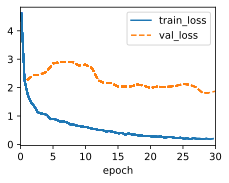

In [12]:

data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = Encoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = Decoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)